In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torchvision.datasets import MNIST
from torch.optim import Adam

from tqdm import tqdm

参考文档：https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb

In [2]:
DATA_DIR = r"D:\Project-Workspace\Python-Projects\DataAnalysis\local-datasets\PyTorch\MNIST"
print(os.path.exists(DATA_DIR))

True


In [3]:
torch.cuda.is_available()

True

In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

batch_size = 100
x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3
epochs = 30

# 数据集
加载MINIS数据集

In [5]:
# download=True
download=False
mnist_transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(DATA_DIR, transform=mnist_transform, train=True, download=download)
test_dataset  = MNIST(DATA_DIR, transform=mnist_transform, train=False, download=download)

In [6]:
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

# 定义简单VAE模型

In [7]:
class VaeEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # encoder部分原论文附录C.2使用的方式是：
        # 1. 先对输入 z 使用一次线性变化 + tanh激活函数：h = tanh(W*z + b)
        # 2. 将 h 分别输入两个线性变换，得到均值和方差： mean = W*h + b, var = W*h + b
        # 这里使用的实现略有修改，对输入 z 使用了两次线性变换，并且激活函数不一样
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        # 激活函数
        self.LeakyReLU = nn.LeakyReLU(0.2)
        # 第1个全连接网络计算均值
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        # 第2个全连接网络计算方差
        self.FC_var = nn.Linear(hidden_dim, latent_dim)

        self.training = True
        
    def forward(self, x):
        # encoder produces mean and log of variance (i.e., parateters of simple tractable normal distribution "q")
        # 先对 输入 进行 两次线性变化+激活函数
        h_ = self.LeakyReLU(self.FC_input(x))
        h_ = self.LeakyReLU(self.FC_input2(h_))
        # 分别计算 均值 和 （对数）方差
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)
        return mean, log_var

In [8]:
class VaeDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        # decoder部分原论文附录C.1中使用的是 3层（2次线性变换），中间一层使用了 tanh 激活函数
        # 这里选择使用 4层（3次线性算子）神经网络 + 一个激活函数，稍微复杂一点
        # 当然，也有使用最简单的MLP的实现：3层（2次线性算子），不使用激活函数
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.FC_hidden(x))
        h = self.LeakyReLU(self.FC_hidden2(h))
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [9]:
class VaeModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)      # sampling epsilon        
        z = mean + var * epsilon                        # reparameterization trick
        return z
        
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))  # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        # 这几个输出后面用于构建两部分的误差
        return x_hat, mean, log_var

# 训练过程

+ 模型输入

In [10]:
encoder = VaeEncoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = VaeDecoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
model = VaeModel(encoder=encoder, decoder=decoder).to(DEVICE)

+ 损失函数和优化器

In [11]:
def loss_function(x, x_hat, mean, log_var):
    # 损失函数由两部分构成
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)

+ 训练过程

In [12]:
print("Start training VAE...")

model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx * batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  175.13683906771703
	Epoch 2 complete! 	Average Loss:  131.77301986057492
	Epoch 3 complete! 	Average Loss:  117.25602521128965
	Epoch 4 complete! 	Average Loss:  112.57518751956385
	Epoch 5 complete! 	Average Loss:  110.14237572060205
	Epoch 6 complete! 	Average Loss:  108.6162407234714
	Epoch 7 complete! 	Average Loss:  107.45412722375835
	Epoch 8 complete! 	Average Loss:  106.47703454324916
	Epoch 9 complete! 	Average Loss:  105.68372763199082
	Epoch 10 complete! 	Average Loss:  104.91529596854132
	Epoch 11 complete! 	Average Loss:  104.44410586654841
	Epoch 12 complete! 	Average Loss:  103.91128943747391
	Epoch 13 complete! 	Average Loss:  103.49292024793927
	Epoch 14 complete! 	Average Loss:  103.06072409093281
	Epoch 15 complete! 	Average Loss:  102.80882626643364
	Epoch 16 complete! 	Average Loss:  102.51237242735289
	Epoch 17 complete! 	Average Loss:  102.31954783036832
	Epoch 18 complete! 	Average Loss:  102.1037639229445

# 检查测试集数据

In [14]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        x_hat, _, _ = model(x)
        
        break

  0%|          | 0/100 [00:01<?, ?it/s]


In [15]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)
    plt.imshow(x[idx].cpu().numpy())

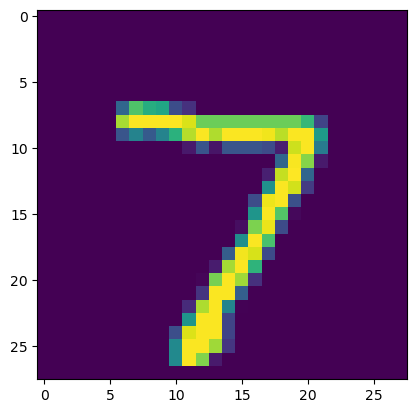

In [16]:
show_image(x, idx=0)

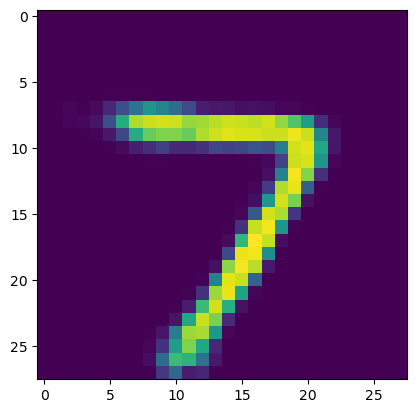

In [17]:
show_image(x_hat, idx=0)

# 生成数据

In [18]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

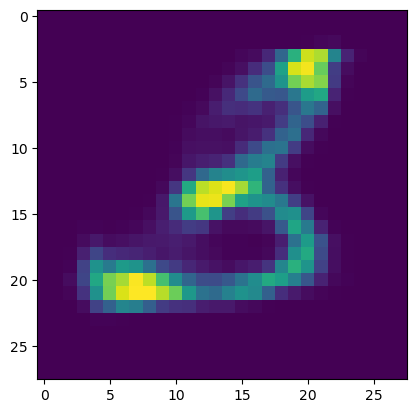

In [19]:
show_image(generated_images, idx=12)

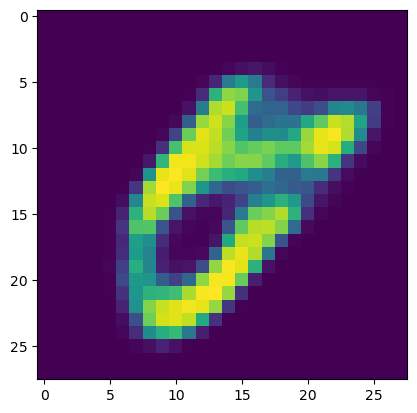

In [20]:
show_image(generated_images, idx=0)